In [65]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ReduceLROnPlateau, LearningRateScheduler
import time

PLOT=True
# PLOT=False

SEQ_LEN=60
OUTPUT_LEN=10
EPOCHS=5

In [66]:
url = "./datasets/DAT_ASCII_EURUSD_M1_2018.csv"
df = pd.read_csv(url, names=list(["date","open", "high", "low", "close", "volume"]), header=None, sep=";")
df.drop("volume", 1, inplace=True)
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df.set_index('date', inplace=True)

df.head()

,open,high,low,close
date,,,,
2018-01-01 17:00:00,1.20037,1.20100,1.20037,1.20100
2018-01-01 17:01:00,1.20083,1.20095,1.20017,1.20030
2018-01-01 17:02:00,1.20035,1.20043,1.20035,1.20043
2018-01-01 17:03:00,1.20041,1.20050,1.20031,1.20046
2018-01-01 17:04:00,1.20049,1.20049,1.20046,1.20048


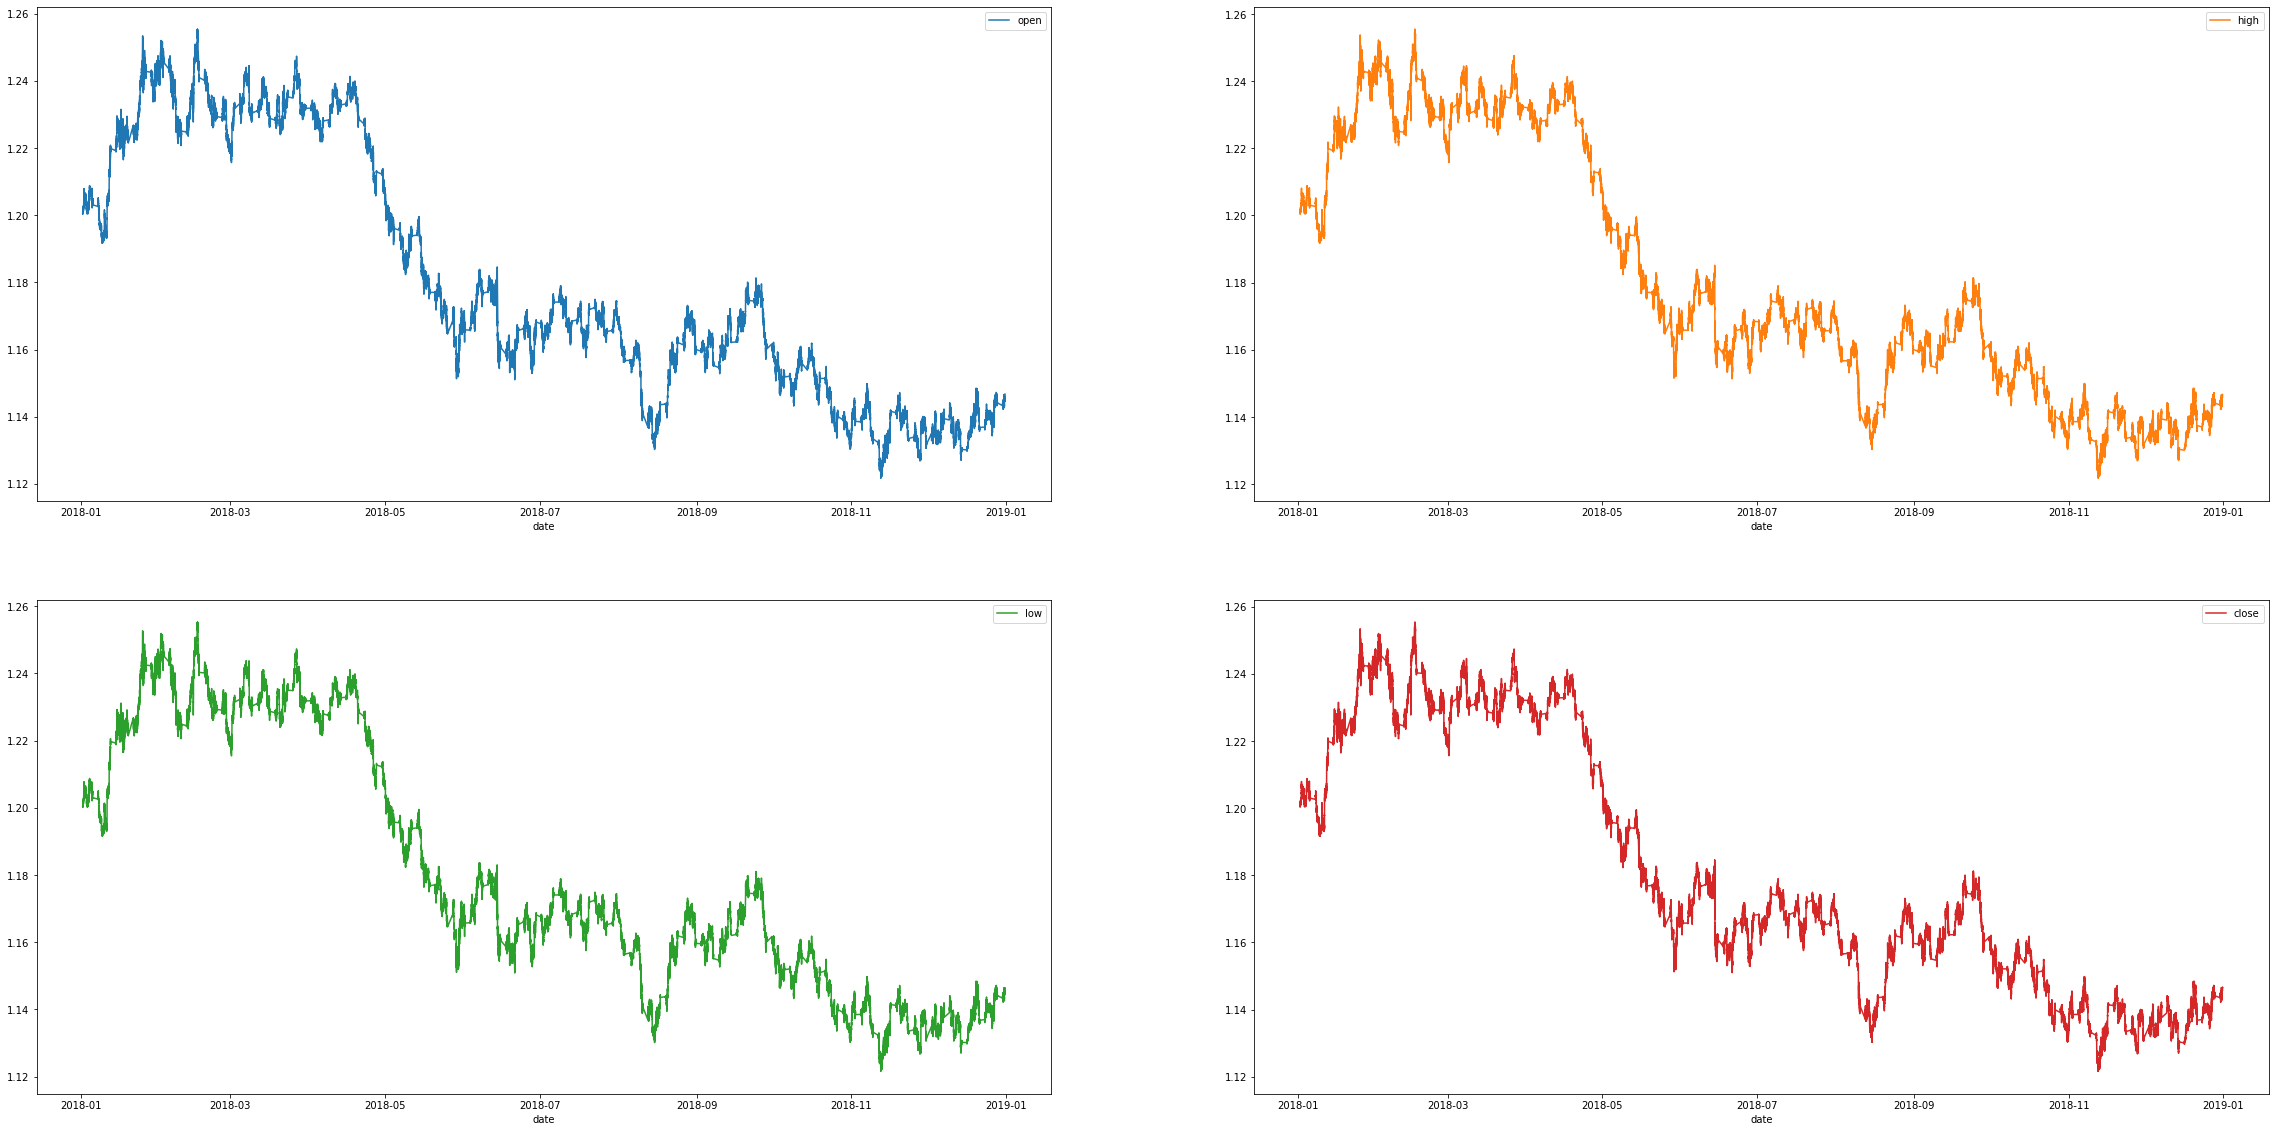

In [67]:
if PLOT:
    df.plot(subplots=True, layout=(2, 2), figsize=(40, 20), sharex=False)

In [68]:
data_set = df.iloc[:, 2:3].values #close
print(data_set)

[[1.20037]
 [1.20017]
 [1.20035]
 ...
 [1.1464 ]
 [1.14639]
 [1.14635]]


In [69]:
print(data_set.shape)

(372607, 1)


In [70]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(data_set)

In [71]:
X_train = []
y_train = []
for i in range(SEQ_LEN, training_set_scaled.size-20):
    X_train.append(training_set_scaled[i-SEQ_LEN:i, 0])
    y_train.append(np.array(training_set_scaled[i+1:i+1+OUTPUT_LEN, 0]))
X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train[0])
print(y_train[0])

[0.58947132 0.58797577 0.58932177 0.58902266 0.59014432 0.59029388
 0.58909744 0.58872355 0.5902191  0.59238765 0.59238765 0.59298587
 0.59261198 0.59268676 0.59246242 0.58939655 0.5895461  0.5895461
 0.58969566 0.58977043 0.58999477 0.59006954 0.59006954 0.59029388
 0.59006954 0.59051821 0.58984521 0.58984521 0.59149032 0.59141554
 0.59178943 0.59193898 0.59238765 0.59193898 0.59328498 0.59590219
 0.59635086 0.59635086 0.59664997 0.59650041 0.59657519 0.59664997
 0.5968743  0.59672474 0.59664997 0.59672474 0.59672474 0.59777163
 0.59650041 0.59657519 0.59664997 0.59664997 0.59664997 0.59679952
 0.59702385 0.59724819 0.59709863 0.59709863 0.5968743  0.59522919]
[0.5882001  0.59051821 0.59178943 0.59201376 0.5918642  0.5925372
 0.59223809 0.59238765 0.5932102  0.5932102 ]


In [72]:
X_train = np.reshape(np.asarray(X_train).astype(np.float32), (X_train.shape[0], X_train.shape[1], 1))
print(X_train[0])

[[0.58947134]
 [0.5879758 ]
 [0.5893218 ]
 [0.58902264]
 [0.59014434]
 [0.5902939 ]
 [0.58909744]
 [0.58872354]
 [0.5902191 ]
 [0.5923877 ]
 [0.5923877 ]
 [0.59298587]
 [0.59261197]
 [0.5926868 ]
 [0.5924624 ]
 [0.58939654]
 [0.5895461 ]
 [0.5895461 ]
 [0.58969563]
 [0.58977044]
 [0.5899948 ]
 [0.59006953]
 [0.59006953]
 [0.5902939 ]
 [0.59006953]
 [0.59051824]
 [0.58984524]
 [0.58984524]
 [0.5914903 ]
 [0.5914155 ]
 [0.5917894 ]
 [0.591939  ]
 [0.5923877 ]
 [0.591939  ]
 [0.59328496]
 [0.5959022 ]
 [0.59635085]
 [0.59635085]
 [0.59664994]
 [0.5965004 ]
 [0.5965752 ]
 [0.59664994]
 [0.5968743 ]
 [0.59672475]
 [0.59664994]
 [0.59672475]
 [0.59672475]
 [0.59777164]
 [0.5965004 ]
 [0.5965752 ]
 [0.59664994]
 [0.59664994]
 [0.59664994]
 [0.5967995 ]
 [0.59702384]
 [0.5972482 ]
 [0.59709865]
 [0.59709865]
 [0.5968743 ]
 [0.5952292 ]]


In [73]:
print(y_train)

[[0.5882001  0.59051821 0.59178943 ... 0.59238765 0.5932102  0.5932102 ]
 [0.59051821 0.59178943 0.59201376 ... 0.5932102  0.5932102  0.59283631]
 [0.59178943 0.59201376 0.5918642  ... 0.5932102  0.59283631 0.5932102 ]
 ...
 [0.18432663 0.18447618 0.18470052 ... 0.18283108 0.18313019 0.18313019]
 [0.18447618 0.18470052 0.18462574 ... 0.18313019 0.18313019 0.18350408]
 [0.18470052 0.18462574 0.18462574 ... 0.18313019 0.18350408 0.18313019]]


In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [75]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(298021, 60, 1)
(74506, 60, 1)
(298021, 10)
(74506, 10)


In [76]:

print(X_train)

[[[0.9202124 ]
  [0.92028713]
  [0.9191655 ]
  ...
  [0.92731625]
  [0.92701715]
  [0.92664325]]

 [[0.5392956 ]
  [0.5392956 ]
  [0.5392956 ]
  ...
  [0.5402677 ]
  [0.54049206]
  [0.54071635]]

 [[0.7671428 ]
  [0.7669932 ]
  [0.7668436 ]
  ...
  [0.76452553]
  [0.7644508 ]
  [0.76452553]]

 ...

 [[0.48216555]
  [0.48246467]
  [0.48224035]
  ...
  [0.482016  ]
  [0.48059523]
  [0.4789501 ]]

 [[0.36812982]
  [0.3671577 ]
  [0.36708292]
  ...
  [0.3644657 ]
  [0.36596125]
  [0.36588648]]

 [[0.6427877 ]
  [0.64331114]
  [0.6437598 ]
  ...
  [0.64645183]
  [0.646377  ]
  [0.6465266 ]]]


In [77]:
model = Sequential()

model.add(LSTM(units=64,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
# model.add(LSTM(units=50,return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(units=64,return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(units=64))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(units=OUTPUT_LEN+10,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=OUTPUT_LEN))

# opt = Adam(lr=0.001, decay=1e-6)

NAME = f"PRED-{int(time.time())}-OUTPUT_LEN={OUTPUT_LEN}-SEQ_LEN={SEQ_LEN}"  
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME, update_freq=25))
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=3, min_lr=0.0001)


def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    return lr / (epoch*3)  

lr_scheduler_cb=LearningRateScheduler(schedule=scheduler)

model.compile(optimizer="adam",loss='mse')

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 60, 64)            16896     
_________________________________________________________________
dropout_9 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 60, 64)            256       
_________________________________________________________________
lstm_7 (LSTM)                (None, 60, 64)            33024     
_________________________________________________________________
dropout_10 (Dropout)         (None, 60, 64)            0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 60, 64)            256       
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)               

In [78]:
model.fit(X_train,y_train,epochs=EPOCHS,batch_size=128,validation_data=(X_test, y_test), callbacks=[tensorboard])

model_file=f"models/{NAME}_model.h5"

model.save(model_file)

score=model.evaluate(X_test, y_test, verbose=1) 

Epoch 1/5
2329/2329 [==============================] - 247s 106ms/step - loss: 0.0244 - val_loss: 0.0022
Epoch 2/5
2329/2329 [==============================] - 263s 113ms/step - loss: 0.0055 - val_loss: 8.6219e-04
Epoch 3/5
2329/2329 [==============================] - 270s 116ms/step - loss: 0.0047 - val_loss: 8.6263e-04
Epoch 4/5
2329/2329 [==============================] - 270s 116ms/step - loss: 0.0039 - val_loss: 5.3150e-04
Epoch 5/5
2329/2329 [==============================] - 33s 14ms/step - loss: 2.7765e-04


In [79]:
print(NAME)

PRED-1594755904-OUTPUT_LEN=10-SEQ_LEN=60


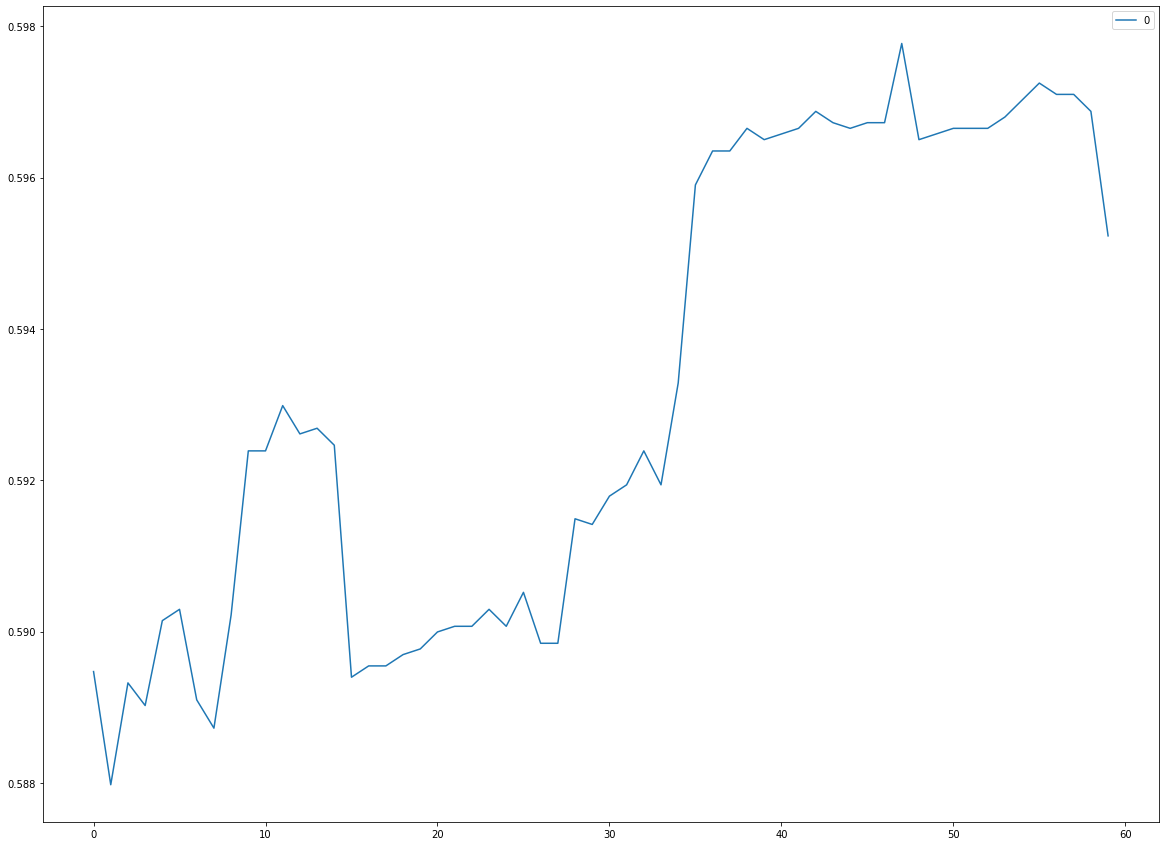

In [80]:
chain_predict = np.array([training_set_scaled[:SEQ_LEN]])
pd.DataFrame(data=chain_predict[0]).plot(figsize=(20, 15), )

In [81]:
output=[]

for i in range(SEQ_LEN,5000):
    if i%100==0 or i==SEQ_LEN:
        print(i/5000*100)
    pred_val=model.predict(chain_predict)
    output.append(pred_val)
    concatenated=np.concatenate((np.array([x[0] for x in chain_predict[0][:SEQ_LEN-OUTPUT_LEN]]), pred_val[0]))
    chain_predict=np.array([concatenated.reshape(-1,1)])

(1, 60, 1) 1.2
(1, 60, 1) 2.0
(1, 60, 1) 4.0
(1, 60, 1) 6.0
(1, 60, 1) 8.0
(1, 60, 1) 10.0
(1, 60, 1) 12.0
(1, 60, 1) 14.000000000000002
(1, 60, 1) 16.0
(1, 60, 1) 18.0
(1, 60, 1) 20.0
(1, 60, 1) 22.0
(1, 60, 1) 24.0
(1, 60, 1) 26.0
(1, 60, 1) 28.000000000000004
(1, 60, 1) 30.0
(1, 60, 1) 32.0
(1, 60, 1) 34.0
(1, 60, 1) 36.0
(1, 60, 1) 38.0
(1, 60, 1) 40.0
(1, 60, 1) 42.0
(1, 60, 1) 44.0
(1, 60, 1) 46.0
(1, 60, 1) 48.0
(1, 60, 1) 50.0
(1, 60, 1) 52.0
(1, 60, 1) 54.0
(1, 60, 1) 56.00000000000001
(1, 60, 1) 57.99999999999999
(1, 60, 1) 60.0
(1, 60, 1) 62.0
(1, 60, 1) 64.0
(1, 60, 1) 66.0
(1, 60, 1) 68.0
(1, 60, 1) 70.0
(1, 60, 1) 72.0
(1, 60, 1) 74.0
(1, 60, 1) 76.0
(1, 60, 1) 78.0
(1, 60, 1) 80.0
(1, 60, 1) 82.0
(1, 60, 1) 84.0
(1, 60, 1) 86.0
(1, 60, 1) 88.0
(1, 60, 1) 90.0
(1, 60, 1) 92.0
(1, 60, 1) 94.0
(1, 60, 1) 96.0
(1, 60, 1) 98.0


In [82]:
print(model.predict(chain_predict))
print()
print(np.array([x[0] for x in output]).flatten())
output=np.array([x[0] for x in output]).flatten()

[[0.73157096 0.7315834  0.73168355 0.7316352  0.7316142  0.7315866
  0.7316445  0.73165417 0.7318409  0.73188573]]

[0.6007895  0.6008024  0.6008748  ... 0.73165417 0.7318409  0.73188573]


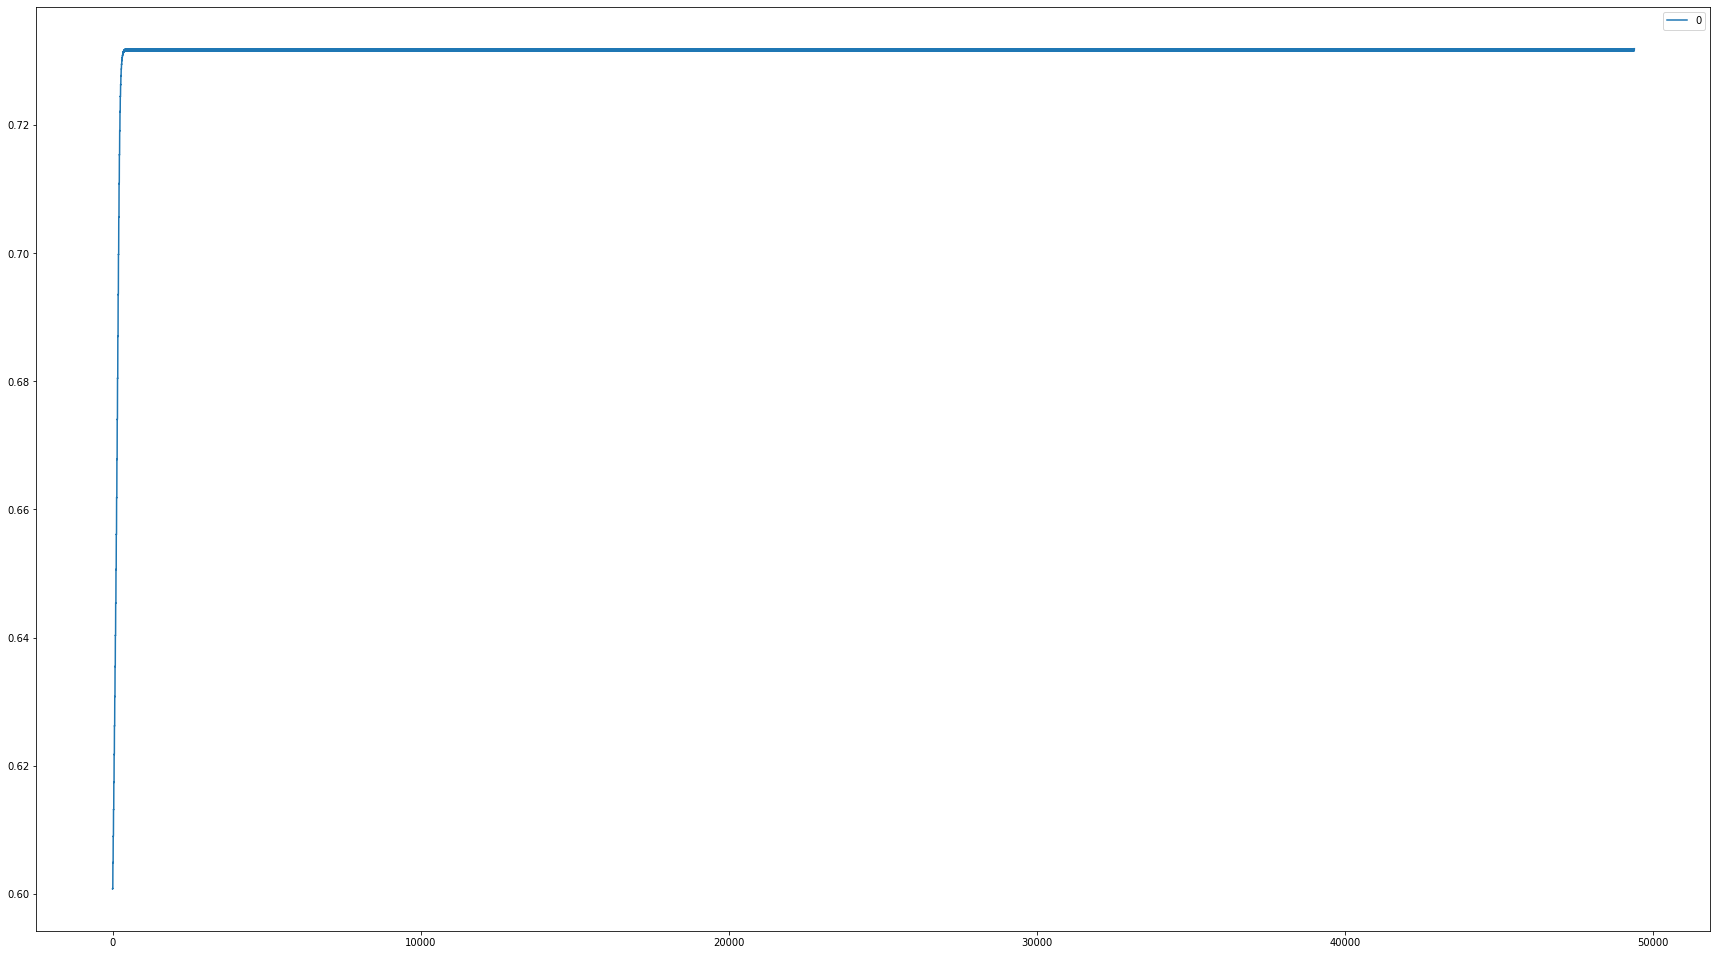

In [83]:
npoutput=sc.inverse_transform(np.array(output).reshape(-1,1))
npoutput=np.array(output).reshape(1,-1)[0]


pd.DataFrame(data=npoutput).plot(figsize=(30, 17))

In [84]:
print(npoutput)

[0.6007895  0.6008024  0.6008748  ... 0.73165417 0.7318409  0.73188573]


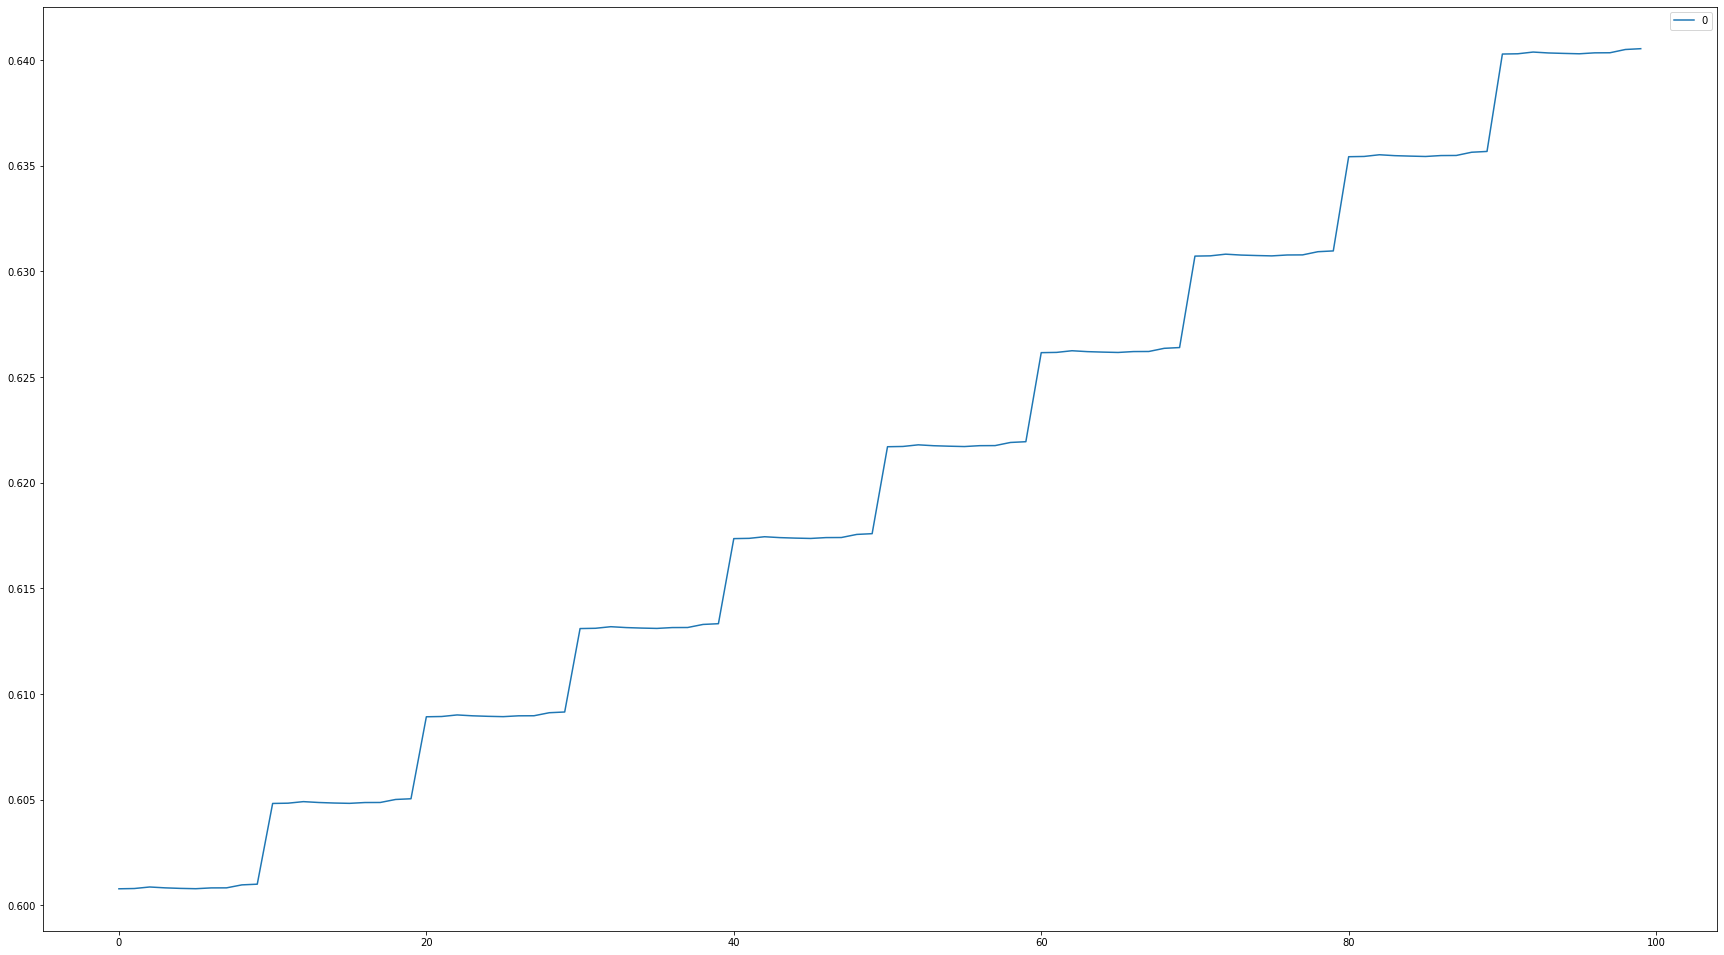

In [87]:
pd.DataFrame(data=npoutput[:100]).plot(figsize=(30, 17))

In [93]:
ytst=model.predict(np.array([X_test[0]]))

In [112]:
y_tst_np=np.array(y_test[0])
xtest_np=np.array([x[0] for x in X_test[0]])
print(xtest_np)
cont=np.concatenate((xtest_np,y_tst_np ))
print(cont.shape)

[0.17871831 0.1790922  0.17924176 0.1797652  0.17946608 0.17954087
 0.17983997 0.17954087 0.17954087 0.17954087 0.17961565 0.18028864
 0.18148509 0.18148509 0.18148509 0.18155986 0.18126075 0.18133552
 0.1811112  0.18066253 0.17998953 0.17998953 0.18021387 0.18118598
 0.1811112  0.1811112  0.1811112  0.17998953 0.17991476 0.18051298
 0.18043819 0.17998953 0.18013908 0.18028864 0.1807373  0.1807373
 0.18066253 0.18230763 0.1827563  0.18327974 0.18260674 0.18283108
 0.18357885 0.1834293  0.1824572  0.18215808 0.1817842  0.18021387
 0.18051298 0.18036342 0.17998953 0.17939131 0.17961565 0.17969042
 0.1797652  0.17998953 0.17998953 0.18028864 0.17998953 0.1800643 ]
(70,)


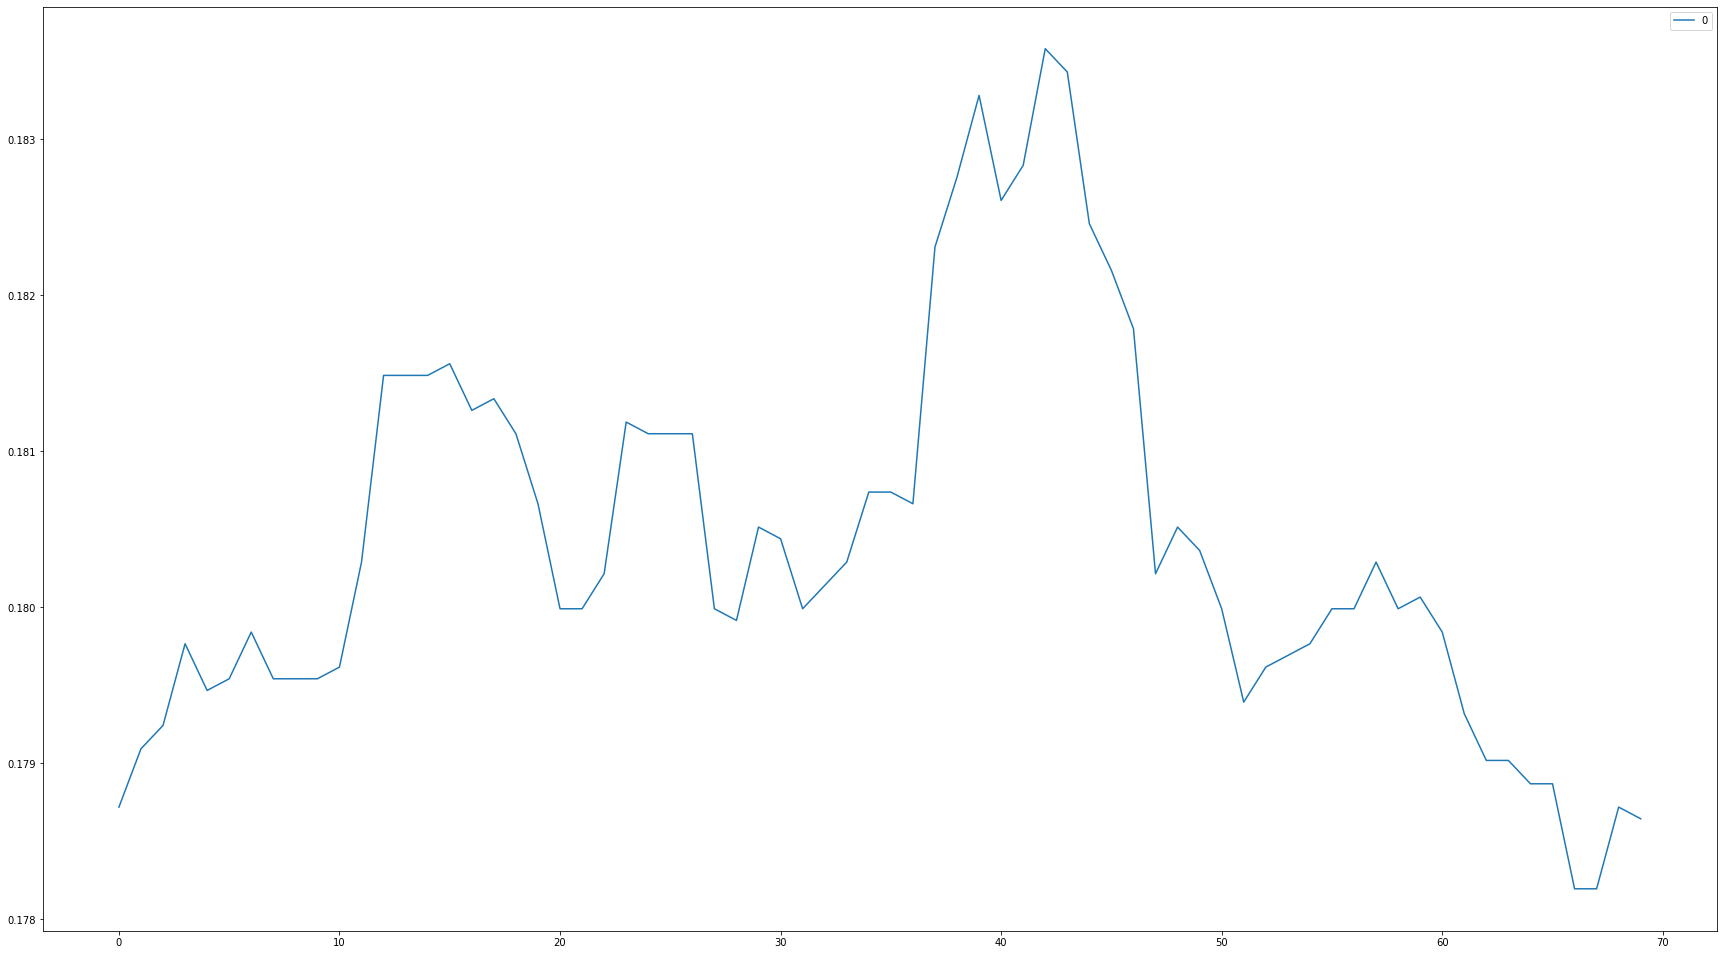

In [113]:
pd.DataFrame(data=cont).plot(figsize=(30, 17))

In [ ]:
# X_train, X_test, y_train, y_test

